In [2]:
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import tensorflow as tf
from pathlib import Path

%matplotlib inline

# テキストデータの操作
1. one-hot エンコーディング
2. トークン埋め込み

## 1. one-hot エンコーディング
エンコーディングには辞書を用いる方法とハッシュ関数を用いる方法がある。ハッシュ関数を使用すると語彙サイズが大きい場合にメモリ効率が高い。しかし、複数の単語へ同一の番号が振られる事がある (**ハッシュ衝突**)

In [2]:
from tensorflow.keras.preprocessing.text import Tokenizer

In [5]:
samples = ["The cat sat on the mat.", "The dog ate my homework."]
tokenizer = Tokenizer(num_words=1000)
tokenizer.fit_on_texts(samples)
tokenizer.word_index

{'the': 1,
 'cat': 2,
 'sat': 3,
 'on': 4,
 'mat': 5,
 'dog': 6,
 'ate': 7,
 'my': 8,
 'homework': 9}

In [6]:
# テキスト -> 整数インデックス
print(tokenizer.texts_to_sequences(samples))

[[1, 2, 3, 4, 1, 5], [1, 6, 7, 8, 9]]


In [7]:
# テキスト -> one-hot エンコーディング
print(tokenizer.texts_to_matrix(samples, mode="binary"))

[[0. 1. 1. ... 0. 0. 0.]
 [0. 1. 0. ... 0. 0. 0.]]


In [8]:
# テキスト -> 整数インデックス (ハッシュ関数)
from tensorflow.keras.preprocessing.text import one_hot, hashing_trick
one_hot(samples[0], 100)

[37, 95, 75, 51, 37, 34]

## 2. 単語埋め込み
**単語ベクトル** とも呼ばれる。ベクトルはデータから学習され、 one-hot よりも低次元なベクトルで扱える。

In [3]:
from tensorflow.keras.datasets import imdb
from tensorflow.keras.preprocessing import sequence

In [7]:
max_features = 10000
max_len = 20
(x_train, y_train), (x_test, y_test) = imdb.load_data(num_words=max_features)

x_train = sequence.pad_sequences(x_train, maxlen=max_len)
x_test = sequence.pad_sequences(x_test, maxlen=max_len)

x_train.shape

(25000, 20)

In [64]:
import tensorflow.keras.models as models
import tensorflow.keras.layers as layers
import tensorflow.keras.optimizers as optimizers

In [61]:
model = models.Sequential()
model.add(layers.Embedding(max_features, 8, input_length=max_len))
model.add(layers.Flatten())
model.add(layers.Dense(1, activation="sigmoid"))

model.compile(loss="binary_crossentropy", metrics=["acc"])
model.summary()

Model: "sequential_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
embedding_1 (Embedding)      (None, 20, 8)             80000     
_________________________________________________________________
flatten_1 (Flatten)          (None, 160)               0         
_________________________________________________________________
dense_1 (Dense)              (None, 1)                 161       
Total params: 80,161
Trainable params: 80,161
Non-trainable params: 0
_________________________________________________________________


In [62]:
result = model.fit(x_train, y_train, epochs=10, batch_size=32, validation_split=0.2)

Train on 20000 samples, validate on 5000 samples
Epoch 1/10
20000/20000 [==============================] - 3s 149us/sample - loss: 0.6687 - acc: 0.6315 - val_loss: 0.6198 - val_acc: 0.7034
Epoch 2/10
20000/20000 [==============================] - 2s 104us/sample - loss: 0.5445 - acc: 0.7530 - val_loss: 0.5277 - val_acc: 0.7288
Epoch 3/10
20000/20000 [==============================] - 2s 103us/sample - loss: 0.4627 - acc: 0.7875 - val_loss: 0.5013 - val_acc: 0.7398
Epoch 4/10
20000/20000 [==============================] - 2s 102us/sample - loss: 0.4221 - acc: 0.8088 - val_loss: 0.4943 - val_acc: 0.7438
Epoch 5/10
20000/20000 [==============================] - 2s 102us/sample - loss: 0.3949 - acc: 0.8243 - val_loss: 0.4939 - val_acc: 0.7534
Epoch 6/10
20000/20000 [==============================] - 2s 103us/sample - loss: 0.3722 - acc: 0.8367 - val_loss: 0.4987 - val_acc: 0.7504
Epoch 7/10
20000/20000 [==============================] - 2s 102us/sample - loss: 0.3524 - acc: 0.8472 - val_lo

## pre-trained vector
* https://nlp.stanford.edu/projects/glove/
* http://www.cl.ecei.tohoku.ac.jp/~m-suzuki/jawiki_vector/

# RNNを理解する
RNN は入力が (batch_size, timestep, feature) の形になっており、ネットワークはループ構造で timestamp を進む。各ループは入力と一つ前のループの出力を足したものを入力とする。出力は (batch_size, timestamp, feature) または (timestamp, feature) となり、前者は一連のループの出力となり後者は最後の出力のみを返す。この構造はモデルが timestamp を進む流れを記憶するため、時系列データを上手く扱える。

In [9]:
max_features = 10000
max_len = 500
batch_size = 32
(x_train, y_train), (x_test, y_test) = imdb.load_data(num_words=max_features)

x_train = sequence.pad_sequences(x_train, maxlen=max_len)
x_test = sequence.pad_sequences(x_test, maxlen=max_len)

x_train.shape

(25000, 500)

In [437]:
x_train.shape

(25000, 500)

In [438]:
y_train.shape

(25000,)

In [10]:
model = models.Sequential()
model.add(layers.Embedding(max_features, batch_size))
model.add(layers.SimpleRNN(32, return_sequences=True))
model.add(layers.Dense(1, activation="sigmoid"))
model.summary()

Model: "sequential_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
embedding (Embedding)        (None, None, 32)          320000    
_________________________________________________________________
simple_rnn (SimpleRNN)       (None, None, 32)          2080      
_________________________________________________________________
dense (Dense)                (None, None, 1)           33        
Total params: 322,113
Trainable params: 322,113
Non-trainable params: 0
_________________________________________________________________


In [ ]:
model.compile(loss="binary_crossentropy", metrics=["acc"])
result = model.fit(x_train, y_train, epochs=10, batch_size=128, validation_split=0.2)

(0, 1)

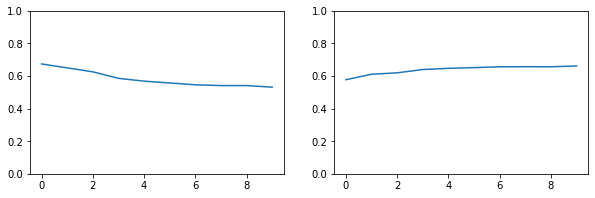

In [84]:
plt.figure(figsize=(10, 3))
plt.subplot(1, 2, 1)
plt.plot(result.history["loss"])
plt.ylim(0, 1)

plt.subplot(1, 2, 2)
plt.plot(result.history["acc"])
plt.ylim(0, 1)

# LSTM 層と GRU 層
RNN には **勾配消失問題** が存在し、これへの対策として幾つかの RNN 層が提案されている。これらは消失する情報を他の経路や変数による保存を用いて補っている。

In [87]:
model = models.Sequential()
model.add(layers.Embedding(max_features, batch_size))
model.add(layers.LSTM(32))
model.add(layers.Dense(1, activation="sigmoid"))
model.summary()

model.compile(loss="binary_crossentropy", metrics=["acc"])
result = model.fit(x_train, y_train, epochs=10, batch_size=128, validation_split=0.2)

Model: "sequential_8"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
embedding_5 (Embedding)      (None, None, 32)          320000    
_________________________________________________________________
lstm (LSTM)                  (None, 32)                8320      
_________________________________________________________________
dense_4 (Dense)              (None, 1)                 33        
Total params: 328,353
Trainable params: 328,353
Non-trainable params: 0
_________________________________________________________________
Train on 20000 samples, validate on 5000 samples
Epoch 1/10
20000/20000 [==============================] - 8s 417us/sample - loss: 0.5032 - acc: 0.7613 - val_loss: 0.3731 - val_acc: 0.8430
Epoch 2/10
20000/20000 [==============================] - 5s 259us/sample - loss: 0.2904 - acc: 0.8885 - val_loss: 0.3889 - val_acc: 0.8226
Epoch 3/10
20000/20000 [=========================

(0, 1)

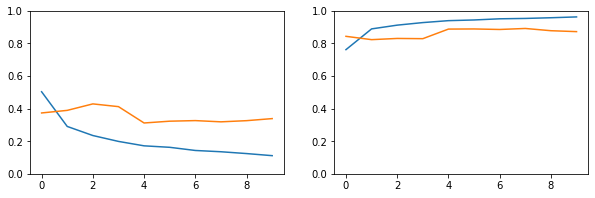

In [91]:
plt.figure(figsize=(10, 3))
plt.subplot(1, 2, 1)
plt.plot(result.history["loss"])
plt.plot(result.history["val_loss"])
plt.ylim(0, 1)

plt.subplot(1, 2, 2)
plt.plot(result.history["acc"])
plt.plot(result.history["val_acc"])
plt.ylim(0, 1)

# RNN の高度な使い方
* リカレントドロップアウト
* リカレント層のスタッキング
* 双方向のリカレント層

## データの準備
気象予測問題を解く

In [5]:
data_dir = tf.keras.utils.get_file(
    "jena_climate.csv.zip",
    "https://s3.amazonaws.com/keras-datasets/jena_climate_2009_2016.csv.zip", extract=True)

csv_path = Path(data_dir) / ".." / "jena_climate_2009_2016.csv"
csv_path = csv_path.resolve()
csv_data_raw = pd.read_csv(csv_path)
csv_data_raw = csv_data_raw.set_index("Date Time")

13574144/13568290 [==============================] - 3s 0us/step


In [6]:
csv_data_raw.head()

,p (mbar),T (degC),Tpot (K),Tdew (degC),rh (%),VPmax (mbar),VPact (mbar),VPdef (mbar),sh (g/kg),H2OC (mmol/mol),rho (g/m**3),wv (m/s),max. wv (m/s),wd (deg)
Date Time,,,,,,,,,,,,,,
01.01.2009 00:10:00,996.52,-8.02,265.40,-8.90,93.3,3.33,3.11,0.22,1.94,3.12,1307.75,1.03,1.75,152.3
01.01.2009 00:20:00,996.57,-8.41,265.01,-9.28,93.4,3.23,3.02,0.21,1.89,3.03,1309.80,0.72,1.50,136.1
01.01.2009 00:30:00,996.53,-8.51,264.91,-9.31,93.9,3.21,3.01,0.20,1.88,3.02,1310.24,0.19,0.63,171.6
01.01.2009 00:40:00,996.51,-8.31,265.12,-9.07,94.2,3.26,3.07,0.19,1.92,3.08,1309.19,0.34,0.50,198.0
01.01.2009 00:50:00,996.51,-8.27,265.15,-9.04,94.1,3.27,3.08,0.19,1.92,3.09,1309.00,0.32,0.63,214.3


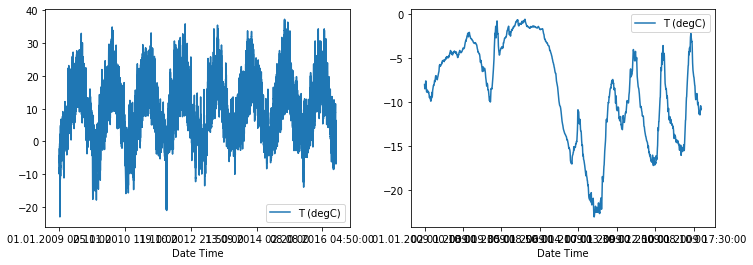

In [7]:
plt.figure(figsize=(12, 4))
ax = plt.subplot(1, 2, 1)
csv_data_raw.loc[:, ["T (degC)"]].plot(ax=ax)

ax = plt.subplot(1, 2, 2)
csv_data_raw.iloc[:1440].loc[:, ["T (degC)"]].plot(ax=ax)

In [8]:
csv_avg = csv_data_raw[:200000].mean(axis=0)
csv_std = csv_data_raw[:200000].std(axis=0)

csv_data = csv_data_raw
csv_data = csv_data - csv_avg
csv_data = csv_data / csv_std
csv_data.describe()

,p (mbar),T (degC),Tpot (K),Tdew (degC),rh (%),VPmax (mbar),VPact (mbar),VPdef (mbar),sh (g/kg),H2OC (mmol/mol),rho (g/m**3),wv (m/s),max. wv (m/s),wd (deg)
count,420551.000000,420551.000000,420551.000000,420551.000000,420551.000000,420551.000000,420551.000000,420551.000000,420551.000000,420551.000000,420551.000000,420551.000000,420551.000000,420551.000000
mean,0.038491,0.042112,0.038693,0.070795,0.039110,0.025139,0.056407,-0.008988,0.055220,0.055270,-0.034163,-0.292047,-0.220088,-0.017010
std,0.985617,0.951522,0.949874,0.939269,0.984984,1.006484,0.996682,1.011672,0.996430,0.996077,0.940838,42.590006,29.612374,1.000788
min,-8.877632,-3.624657,-3.635134,-4.110953,-3.730658,-1.616945,-2.026386,-0.844136,-2.016468,-2.023768,-3.720127,-6508.334156,-4291.697971,-2.034523
25%,-0.552607,-0.645844,-0.638461,-0.587305,-0.606435,-0.728682,-0.735323,-0.664397,-0.733482,-0.732633,-0.706638,-0.755533,-0.776387,-0.592483
50%,0.081793,0.038707,0.036153,0.107657,0.235897,-0.203267,-0.104084,-0.391690,-0.106995,-0.104704,-0.087653,-0.254449,-0.261516,0.252651
75%,0.687892,0.722128,0.713001,0.784476,0.839699,0.548440,0.727246,0.250825,0.722070,0.725479,0.594406,0.461385,0.502210,0.668291
max,3.120545,3.185833,3.148984,2.604214,1.473391,6.552993,4.531355,8.661363,4.597288,4.565957,4.142858,17.140326,8.551367,2.121876


## ベースラインを求める

In [10]:
delay = 6
csv_x = csv_data.values.astype(np.float32)
csv_y = csv_data.loc[:, "T (degC)"].values.astype(np.float32)

mae = np.mean(np.abs(csv_x[:-delay, 1] - csv_x[delay:, 1]))
print("MAE:", mae)

MAE: 0.08063179


## 基本的アプローチ

In [33]:
def generate(
    x_values, y_values, lookback, delay, min_index = 0, max_index = None,
    shuffle=False, batch_size=128, step=6):
    
    x_values = x_values[min_index:max_index]
    y_values = y_values[min_index:max_index]
    
    ds_x = tf.data.Dataset.from_tensor_slices(x_values)
    ds_y = tf.data.Dataset.from_tensor_slices(y_values)
    ds_x = ds_x.window(lookback, shift=1, stride=step, drop_remainder=True)
    ds_x = ds_x.flat_map(lambda item: item.batch(lookback))
    ds_y = ds_y.skip(lookback - 1 + delay)
    
    ds_xy = tf.data.Dataset.zip((ds_x, ds_y))
    ds_xy = ds_xy.cache()
    ds_xy = ds_xy.shuffle(1000) if shuffle else ds_xy
    
    ds_x = ds_xy.map(lambda x, y: x, num_parallel_calls=tf.data.experimental.AUTOTUNE)
    ds_x = ds_x.batch(batch_size)
    ds_y = ds_xy.map(lambda x, y: y, num_parallel_calls=tf.data.experimental.AUTOTUNE)
    ds_y = ds_y.batch(batch_size)
    ds_xy = tf.data.Dataset.zip((ds_x, ds_y))
    ds_xy = ds_xy.prefetch(buffer_size=tf.data.experimental.AUTOTUNE)
    ds_steps = -(-(len(x_values) - (1 + (lookback - 1) * step) - delay + 1) // batch_size)
    
    return ds_xy, ds_steps


In [34]:
# 直近 10日間 を入力
lookback = 240
# 時間分解能 1時間毎
step = 6
# 24時間後の気温を予測
delay = 24
batch_size = 128

# モデルへのデータ供給用データセットを作成
train_gen, train_stp = generate(csv_x, csv_y, lookback, delay, 0, 200000, batch_size=batch_size, step=step)
valid_gen, valid_stp = generate(csv_x, csv_y, lookback, delay, 200001, 300000, batch_size=batch_size, step=step)
test_gen , _         = generate(csv_x, csv_y, lookback, delay, 300001, None, batch_size=batch_size, step=step)

In [13]:
model = models.Sequential()
model.add(layers.Flatten(input_shape=(lookback, csv_x.shape[1])))
model.add(layers.Dense(32, activation="relu"))
model.add(layers.Dense(1))
model.compile(loss="mae")

In [ ]:
%%time
res = model.fit(
    train_gen.repeat(), steps_per_epoch=train_stp, epochs=20,
    validation_data=valid_gen, validation_steps=valid_stp)

## 最初のRNNベースライン

In [35]:
model = models.Sequential()
model.add(layers.GRU(32, input_shape=(lookback, csv_x.shape[1])))
model.add(layers.Dense(1))
model.compile(loss="mae")

In [42]:
%%time
res = model.fit(
    train_gen.repeat(), steps_per_epoch=train_stp, epochs=20,
    validation_data=valid_gen, validation_steps=valid_stp)

Train for 1552 steps, validate for 770 steps
Epoch 1/20
1552/1552 [==============================] - 26s 17ms/step - loss: 0.0333 - val_loss: 0.0243
Epoch 2/20
1552/1552 [==============================] - 26s 17ms/step - loss: 0.0329 - val_loss: 0.0322
Epoch 3/20
1552/1552 [==============================] - 26s 17ms/step - loss: 0.0320 - val_loss: 0.0236
Epoch 4/20
1552/1552 [==============================] - 26s 17ms/step - loss: 0.0333 - val_loss: 0.0213
Epoch 5/20
1552/1552 [==============================] - 26s 17ms/step - loss: 0.0319 - val_loss: 0.0248
Epoch 6/20
1552/1552 [==============================] - 26s 17ms/step - loss: 0.0323 - val_loss: 0.0235
Epoch 7/20
1552/1552 [==============================] - 26s 17ms/step - loss: 0.0338 - val_loss: 0.0224
Epoch 8/20
1552/1552 [==============================] - 26s 17ms/step - loss: 0.0323 - val_loss: 0.0294
Epoch 9/20
1552/1552 [==============================] - 26s 17ms/step - loss: 0.0326 - val_loss: 0.0371
Epoch 10/20
1552/15

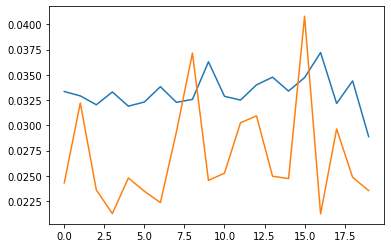

In [45]:
plt.plot(res.history["loss"])
plt.plot(res.history["val_loss"])
# plt.ylim(0, 1)

## リカレントドロップアウトによる過学習抑制
RNN の内部ループにドロップアウトを入れると学習が阻害されるため、代わりにリカレントドロップアウトがある。これは RNN のループ内で毎回ドロップマスクを変えず、一連のループ内で同じマスクを使う。この方法ではドロップアウトは学習を阻害しない。

In [48]:
model = models.Sequential()
model.add(layers.GRU(32, dropout=0.2, recurrent_dropout=0.2, input_shape=(lookback, csv_x.shape[1])))
model.add(layers.Dense(1))
model.compile(loss="mae")

In [49]:
%%time
res = model.fit(
    train_gen.repeat(), steps_per_epoch=train_stp, epochs=40,
    validation_data=valid_gen, validation_steps=valid_stp)

Train for 1552 steps, validate for 770 steps
Epoch 1/40
1552/1552 [==============================] - 782s 504ms/step - loss: 0.4388 - val_loss: 0.7317
Epoch 2/40
1552/1552 [==============================] - 780s 503ms/step - loss: 0.4166 - val_loss: 0.7343
Epoch 3/40
1552/1552 [==============================] - 780s 502ms/step - loss: 0.4047 - val_loss: 0.6432
Epoch 4/40
1552/1552 [==============================] - 780s 503ms/step - loss: 0.3870 - val_loss: 0.4900
Epoch 5/40
1552/1552 [==============================] - 780s 503ms/step - loss: 0.3671 - val_loss: 0.4331
Epoch 6/40
1552/1552 [==============================] - 780s 503ms/step - loss: 0.3583 - val_loss: 0.3933
Epoch 7/40
1552/1552 [==============================] - 780s 503ms/step - loss: 0.3516 - val_loss: 0.3655
Epoch 8/40
1552/1552 [==============================] - 781s 503ms/step - loss: 0.3468 - val_loss: 0.3499
Epoch 9/40
1552/1552 [==============================] - 781s 503ms/step - loss: 0.3407 - val_loss: 0.3306
E

(0, 1)

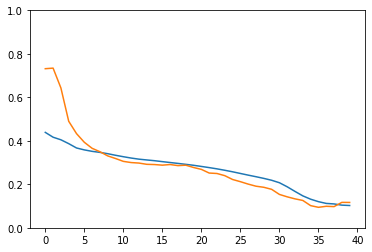

In [50]:
plt.plot(res.history["loss"])
plt.plot(res.history["val_loss"])
plt.ylim(0, 1)

## RNN層のスタッキング
ここまでの RNN 層は最終出力のみを後続層に流していたが、 `return_sequences=True` を指定するとループ中の出力を出力でき、ここから更に RNN 層を重ねられる。

## 双方向の RNN
データの入力順序を通常の順序の他、逆順に入れる層を入れると異なる角度からも学習し性能向上することがある。組み合わせる際には 2 種類の層の後ろに Concatenate 層を作る。自然言語処理などで使われる。

# CNN のシーケンス処理への適用
時間軸は空間の構造として畳込みでも学習できる事がある (1次元畳込み)。 RNN よりも計算量が低く、特定のタスクでは良い選択肢になる。

In [51]:
max_features = 10000
max_len = 500

(x_train, y_train), (x_test, y_test) = imdb.load_data(num_words=max_features)
x_train = sequence.pad_sequences(x_train, maxlen=max_len)
x_test = sequence.pad_sequences(x_test, maxlen=max_len)

17465344/17464789 [==============================] - 2s 0us/step


In [71]:
model = models.Sequential()
model.add(layers.Embedding(max_features, 128, input_length=max_len))
model.add(layers.Conv1D(32, 7, activation="relu"))
model.add(layers.GlobalMaxPooling1D())
model.add(layers.Dense(1))

In [72]:
model.compile(optimizers.RMSprop(1e-4), loss="binary_crossentropy", metrics=["acc"])
res = model.fit(x_train, y_train, epochs=10, batch_size=128, validation_split=0.2)

Train on 20000 samples, validate on 5000 samples
Epoch 1/10
20000/20000 [==============================] - 5s 255us/sample - loss: 1.1994 - acc: 0.5058 - val_loss: 0.6880 - val_acc: 0.5602
Epoch 2/10
20000/20000 [==============================] - 5s 226us/sample - loss: 0.6690 - acc: 0.6344 - val_loss: 0.6606 - val_acc: 0.6588
Epoch 3/10
20000/20000 [==============================] - 5s 225us/sample - loss: 0.6194 - acc: 0.7638 - val_loss: 0.6113 - val_acc: 0.7284
Epoch 4/10
20000/20000 [==============================] - 5s 227us/sample - loss: 0.5476 - acc: 0.8008 - val_loss: 0.5402 - val_acc: 0.7412
Epoch 5/10
20000/20000 [==============================] - 5s 228us/sample - loss: 0.4779 - acc: 0.7883 - val_loss: 0.4971 - val_acc: 0.7670
Epoch 6/10
20000/20000 [==============================] - 4s 225us/sample - loss: 0.4233 - acc: 0.8119 - val_loss: 0.4637 - val_acc: 0.8006
Epoch 7/10
20000/20000 [==============================] - 5s 227us/sample - loss: 0.3780 - acc: 0.8414 - val_lo

(0, 1)

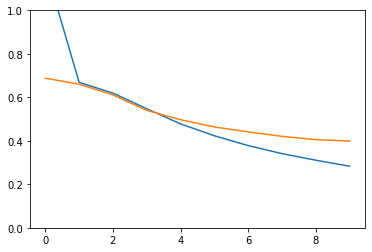

In [74]:
plt.plot(res.history["loss"])
plt.plot(res.history["val_loss"])
plt.ylim(0, 1)

# CNN と RNN を組み合わせる
Conv1D を RNN 層の前に追加すると高レベルな特徴量からなるダウンサンプリングされたシーケンスを RNN へ入力できる。RNN へ入力するシーケンスの長さが非現実的なサイズの場合に有効な手法となる

* Conv1D は時間的なパターン処理に適している
* 一般に Conv2D と変わらない。Conv1D - MaxPooling1D、最後に GlobalMaxPooling1D や Flatten が入る
* RNN 層への入力前に使うと RNN に有益な表現を抽出できる

In [91]:
# 直近 10日間 を入力
lookback = 480
# 時間分解能 1時間毎
step = 3
# 24時間後の気温を予測
delay = 48
batch_size = 128

# モデルへのデータ供給用データセットを作成
train_gen, train_stp = generate(csv_x, csv_y, lookback, delay, 0, 200000, batch_size=batch_size, step=step)
valid_gen, valid_stp = generate(csv_x, csv_y, lookback, delay, 200001, 300000, batch_size=batch_size, step=step)
test_gen , _         = generate(csv_x, csv_y, lookback, delay, 300001, None, batch_size=batch_size, step=step)

In [92]:
model = models.Sequential()
model.add(layers.Conv1D(32, 5, activation="relu", input_shape=(lookback, csv_x.shape[1])))
model.add(layers.MaxPool1D(3))
model.add(layers.Conv1D(32, 5, activation="relu"))
model.add(layers.GRU(32, dropout=0.1, recurrent_dropout=0.5))
model.add(layers.Dense(1))
model.summary()

Model: "sequential_18"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv1d_18 (Conv1D)           (None, 476, 32)           2272      
_________________________________________________________________
max_pooling1d_7 (MaxPooling1 (None, 158, 32)           0         
_________________________________________________________________
conv1d_19 (Conv1D)           (None, 154, 32)           5152      
_________________________________________________________________
gru_10 (GRU)                 (None, 32)                6336      
_________________________________________________________________
dense_18 (Dense)             (None, 1)                 33        
Total params: 13,793
Trainable params: 13,793
Non-trainable params: 0
_________________________________________________________________


In [93]:
%%time
model.compile(loss="mae")
res = model.fit(
    train_gen.repeat(), steps_per_epoch=train_stp, epochs=20,
    validation_data=valid_gen, validation_steps=valid_stp)

Train for 1551 steps, validate for 770 steps
Epoch 1/20
1551/1551 [==============================] - 581s 375ms/step - loss: 0.3639 - val_loss: 0.6734
Epoch 2/20
1551/1551 [==============================] - 512s 330ms/step - loss: 0.3545 - val_loss: 0.5002
Epoch 3/20
1551/1551 [==============================] - 510s 329ms/step - loss: 0.3365 - val_loss: 0.4056
Epoch 4/20
1551/1551 [==============================] - 510s 329ms/step - loss: 0.3324 - val_loss: 0.3454
Epoch 5/20
1551/1551 [==============================] - 509s 328ms/step - loss: 0.3256 - val_loss: 0.4008
Epoch 6/20
1551/1551 [==============================] - 509s 328ms/step - loss: 0.3219 - val_loss: 0.3754
Epoch 7/20
1551/1551 [==============================] - 510s 329ms/step - loss: 0.3175 - val_loss: 0.3732
Epoch 8/20
1551/1551 [==============================] - 509s 328ms/step - loss: 0.3143 - val_loss: 0.3938
Epoch 9/20
1551/1551 [==============================] - 510s 329ms/step - loss: 0.3133 - val_loss: 0.3757
E

(0, 1)

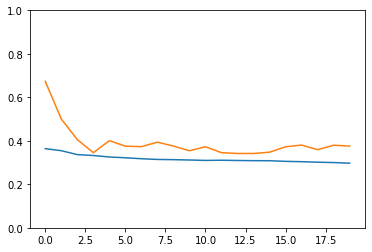

In [94]:
plt.plot(res.history["loss"])
plt.plot(res.history["val_loss"])
plt.ylim(0, 1)